In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load merged dataset (if not already loaded)
merged_df = pd.read_excel("merged_dataset.xlsx", index_col=0, engine='openpyxl')

# 1️⃣ Antibiotic columns (labels)
antibiotic_cols = [
    'AMI  Interpretation', 'AMP Interpretation', 'AZI Interpretation',
    'FOT Interpretation', 'TAZ  Interpretation', 'CHL Interpretation',
    'CIP Interpretation', 'COL Interpretation', 'GEN Interpretation',
    'MERO Interpretation', 'NAL  Interpretation', 'SMX Interpretation',
    'TET  Interpretation', 'TGC  Interpretation', 'TMP Interpretation'
]


In [ ]:
print(merged_df.shape)

(220, 4694)


In [ ]:
# Clean up label strings (remove spaces, force uppercase)
merged_df[antibiotic_cols] = merged_df[antibiotic_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper()
)

# 2️⃣ Encode the labels (R/S → numbers)
labels_encoded = merged_df[antibiotic_cols].apply(
    lambda col: LabelEncoder().fit_transform(col.astype(str))
)

In [ ]:

#%%
# 3️⃣ Extract feature matrix (gene counts only)
# Drop antibiotic columns and any non-numeric or ID columns
X = merged_df.drop(columns=antibiotic_cols)

# Remove columns with non-numeric data (like sample IDs)
X = X.select_dtypes(include=['number'])

# 4️⃣ Align features and labels by index
common_samples = X.index.intersection(labels_encoded.index)
X_common = X.loc[common_samples]
y_common = labels_encoded.loc[common_samples]


In [ ]:
print(merged_df[antibiotic_cols].apply(pd.Series.unique))


AMI  Interpretation            [S, I]
AMP Interpretation             [R, S]
AZI Interpretation             [S, R]
FOT Interpretation             [R, S]
TAZ  Interpretation         [R, I, S]
CHL Interpretation     [S, R, I, NAN]
CIP Interpretation     [R, I, S, NAN]
COL Interpretation             [R, I]
GEN Interpretation          [S, R, I]
MERO Interpretation            [S, R]
NAL  Interpretation            [R, S]
SMX Interpretation                [R]
TET  Interpretation            [R, S]
TGC  Interpretation         [S, R, I]
TMP Interpretation             [S, R]
dtype: object


In [ ]:

# Count rows with at least one NAM
rows_with_nam = (merged_df[antibiotic_cols] == "NAN").any(axis=1).sum()
print("\nRows with at least one NAN:", rows_with_nam)




Rows with at least one NAN: 2


In [ ]:
merged_df = merged_df[~(merged_df[antibiotic_cols] == "NAN").any(axis=1)]


In [ ]:
cols_to_drop = ["SMX Interpretation"]
df = merged_df.drop(columns=cols_to_drop)


In [ ]:
display(df.head())

,Genomic ID,AMI Interpretation,AMP Interpretation,AZI Interpretation,FOT Interpretation,TAZ Interpretation,CHL Interpretation,CIP Interpretation,COL Interpretation,GEN Interpretation,...,PSLT102,PSLT103,PSLT104,PSLT105,PSLT106,PSLT107,PSLT108,PSLT109,PSLT110,PSLT111
ERR12322786,ERR12322786,S,R,S,R,R,S,R,R,S,...,-0.186713,-0.377554,-0.289513,0,0,0,-0.307386,0,-0.280356,-0.282647
ERR12322655,ERR12322655,S,R,S,R,R,S,R,R,S,...,-0.186713,-0.377554,-0.289513,0,0,0,-0.381220,0,-0.280356,-0.282647
ERR12322645,ERR12322645,S,R,S,R,I,R,R,I,S,...,-0.186713,-0.377554,-0.289513,0,0,0,-0.381220,0,-0.280356,-0.282647
ERR12322736,ERR12322736,S,R,S,R,I,R,I,I,S,...,-0.186713,2.012695,-0.289513,0,0,0,1.487296,0,-0.280356,-0.282647
ERR12322626,ERR12322626,S,R,S,R,I,R,R,I,S,...,-0.186713,-0.377554,-0.289513,0,0,0,-0.381220,0,-0.280356,-0.282647


In [ ]:
antibiotic_cols = [
    'AMI  Interpretation', 'AMP Interpretation', 'AZI Interpretation',
    'FOT Interpretation', 'TAZ  Interpretation', 'CHL Interpretation',
    'CIP Interpretation', 'COL Interpretation', 'GEN Interpretation',
    'MERO Interpretation', 'NAL  Interpretation',
    'TET  Interpretation', 'TGC  Interpretation', 'TMP Interpretation'
]
# Clean up label strings (remove spaces, force uppercase)
df[antibiotic_cols] = df[antibiotic_cols].apply(
    lambda col: col.astype(str).str.strip().str.upper()
)

# 2️⃣ Encode the labels (R/S → numbers)
labels_encoded = df[antibiotic_cols].apply(
    lambda col: LabelEncoder().fit_transform(col.astype(str))
)

#%%
# 3️⃣ Extract feature matrix (gene counts only)
# Drop antibiotic columns and any non-numeric or ID columns
X = df.drop(columns=antibiotic_cols)

# Remove columns with non-numeric data (like sample IDs)
X = X.select_dtypes(include=['number'])

# 4️⃣ Align features and labels by index
common_samples = X.index.intersection(labels_encoded.index)
X_common = X.loc[common_samples]
y_common = labels_encoded.loc[common_samples]


In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# X_common: full feature set (numeric)
# y_common: multi-output label DataFrame (binary or categorical)

mi_matrix = []

# Compute MI for each output column
for col in y_common.columns:
    mi = mutual_info_classif(
        X_common,
        y_common[col],
        discrete_features=False,
        random_state=42
    )
    mi_matrix.append(mi)

mi_matrix = np.array(mi_matrix)  # shape (n_outputs, n_features)

# Aggregate across all outputs
# mean → balanced weighting, min → consistent relevance, sum → total contribution
avg_mi = mi_matrix.mean(axis=0)
min_mi = mi_matrix.min(axis=0)
sum_mi = mi_matrix.sum(axis=0)

# Choose aggregation type: mean is a good default
aggregated_mi = avg_mi

# Sort features by aggregated score
mi_scores = pd.Series(aggregated_mi, index=X_common.columns).sort_values(ascending=False)

# Select top 200 features
top_features = mi_scores.head(200).index
X_selected = X_common[top_features]

print(f"Selected {len(top_features)} features out of {X_common.shape[1]}")


Selected 200 features out of 4678


In [ ]:
print(X.columns.tolist())


['STM0001', 'STM0002', 'STM0003', 'STM0004', 'STM0005', 'STM0006', 'STM0007', 'STM0008', 'STM0009', 'STM0010', 'STM0011', 'STM0012', 'STM0013', 'STM0014', 'STM0015', 'STM0016', 'STM0017', 'STM0018', 'STM0019', 'STM0020', 'STM0021', 'STM0022', 'STM0023', 'STM0024', 'STM0025', 'STM0026', 'STM0027', 'STM0028', 'STM0029', 'STM0030', 'STM0031', 'STM0032', 'STM0033', 'STM0034', 'STM0035', 'STM0036', 'STM0037', 'STM0038', 'STM0039', 'STM0040', 'STM0041', 'STM0042', 'STM0043', 'STM0044', 'STM0045', 'STM0046', 'STM0047', 'STM0048', 'STM0049', 'STM0050', 'STM0051', 'STM0052', 'STM0053', 'STM0054', 'STM0055', 'STM0056', 'STM0057', 'STM0058', 'STM0059', 'STM0060', 'STM0061', 'STM0062', 'STM0063', 'STM0064', 'STM0065', 'STM0066', 'STM0067', 'STM0068', 'STM0069', 'STM0070', 'STM0071', 'STM0072', 'STM0073', 'STM0074', 'STM0075', 'STM0076', 'STM0077', 'STM0078', 'STM0079', 'STM0080', 'STM0081', 'STM0082', 'STM0083', 'STM0084', 'STM0085', 'STM0086', 'STM0087', 'STM0088', 'STM0089', 'STM0090', 'STM0091'

In [ ]:
from sklearn.model_selection import train_test_split

# Align indices just in case
common_samples = X_selected.index.intersection(y_common.index)
X_sel_common = X_selected.loc[common_samples]
y_sel_common = y_common.loc[common_samples]

# Step 1: Split off 20% (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sel_common, y_sel_common, test_size=0.2, random_state=42
)

# Step 2: Split the remaining 20% equally into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")




Train: (174, 200), Val: (22, 200), Test: (22, 200)


In [ ]:
display(y_train)

,AMI Interpretation,AMP Interpretation,AZI Interpretation,FOT Interpretation,TAZ Interpretation,CHL Interpretation,CIP Interpretation,COL Interpretation,GEN Interpretation,MERO Interpretation,NAL Interpretation,TET Interpretation,TGC Interpretation,TMP Interpretation
ERR12322617,1,0,1,0,1,2,0,0,1,1,0,0,2,0
ERR12322559,1,0,1,0,0,2,2,0,1,1,0,0,2,0
ERR12322648,1,0,1,0,1,1,1,0,2,1,0,0,2,1
ERR12322765,1,0,1,0,1,1,1,0,2,1,0,0,2,1
ERR12322582,1,0,1,0,1,2,0,0,1,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR12322787,1,0,1,0,0,2,0,0,2,1,1,0,2,1
ERR12322623,1,0,0,0,1,1,1,0,2,1,0,0,2,1
ERR12322785,1,0,1,0,0,1,1,0,2,1,0,0,0,1
ERR12322604,1,0,0,0,0,1,1,0,2,1,0,0,0,1


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
)

model.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                       n_jobs=-1,
                                                       random_state=42))

In [ ]:
print(X.index.name)

print(X_test.index)

None
Index(['ERR12322562', 'ERR12322720', 'ERR12322556', 'ERR12322676',
       'ERR12322598', 'ERR12322727', 'ERR12322674', 'ERR12322763',
       'ERR12322654', 'ERR12322600', 'ERR12322548', 'ERR12322650',
       'ERR12322749', 'ERR12322743', 'ERR12322769', 'ERR12322761',
       'ERR12322751', 'ERR12321543', 'ERR12322591', 'ERR12322576',
       'ERR12331339', 'ERR12322595'],
      dtype='object')


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

train_accs, val_accs = [], []

# Predict once for efficiency
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

for i, col in enumerate(y_train.columns):
    # Compute accuracy per antibiotic
    train_acc = accuracy_score(y_train.iloc[:, i], y_train_pred[:, i])
    val_acc = accuracy_score(y_val.iloc[:, i], y_val_pred[:, i])

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\n===== Antibiotic: {col} =====")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Val Accuracy:   {val_acc:.3f}")
    print("------------------------------")
    print(classification_report(y_val.iloc[:, i], y_val_pred[:, i], zero_division=0))

# Summary table
acc_df = pd.DataFrame({
    "Antibiotic": y_train.columns,
    "Train Accuracy": train_accs,
    "Val Accuracy": val_accs
})

print("\n=== Accuracy Summary ===")
print(acc_df)
print(f"\nOverall Mean Accuracies → "
      f"Train: {acc_df['Train Accuracy'].mean():.3f}, "
      f"Val: {acc_df['Val Accuracy'].mean():.3f}")



===== Antibiotic: AMI  Interpretation =====
Train Accuracy: 1.000
Val Accuracy:   1.000
------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


===== Antibiotic: AMP Interpretation =====
Train Accuracy: 1.000
Val Accuracy:   1.000
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


===== Antibiotic: AZI Interpretation =====
Train Accuracy: 1.000
Val Accuracy:   0.909
------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "estimator__n_estimators": [200, 400, 600],
    "estimator__max_depth": [None, 10, 20],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 5],
    "estimator__max_features": ['sqrt', 'log2']
}

search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=10,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_val, y_val)
best_model = search.best_estimator_
print(search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'estimator__n_estimators': 600, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 5, 'estimator__max_features': 'log2', 'estimator__max_depth': 20}


In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Rebuild model with the best parameters
best_model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=600,
        min_samples_split=5,
        min_samples_leaf=5,
        max_features='log2',
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
)

# Fit it again on your training set
best_model.fit(X_train, y_train)



MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=20,
                                                       max_features='log2',
                                                       min_samples_leaf=5,
                                                       min_samples_split=5,
                                                       n_estimators=600,
                                                       n_jobs=-1,
                                                       random_state=42))

In [ ]:
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test)

# Reports
for i, col in enumerate(y_train.columns):
    print(f"\n===== Antibiotic: {col} =====")
    print("---- Training set ----")
    print(classification_report(y_train.iloc[:, i], y_train_pred[:, i], zero_division=0))

    print("---- Test set ----")
    print(classification_report(y_test.iloc[:, i], y_test_pred[:, i], zero_division=0))



===== Antibiotic: AMI  Interpretation =====
---- Training set ----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00       173

    accuracy                           1.00       174
   macro avg       1.00      1.00      1.00       174
weighted avg       1.00      1.00      1.00       174

---- Test set ----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


===== Antibiotic: AMP Interpretation =====
---- Training set ----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00         1

    accuracy                           1.00       174
   macro avg       1.00     

In [ ]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)

for i, col in enumerate(y_test.columns):
    print(f"\n===== Antibiotic: {col} =====")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], zero_division=0))



===== Antibiotic: AMI  Interpretation =====
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


===== Antibiotic: AMP Interpretation =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


===== Antibiotic: AZI Interpretation =====
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      1.00      0.93        19

    accuracy                           0.86        22
   macro avg       0.43      0.50      0.46        22
weighted avg       0.75      0.86      0.80      

In [ ]:
model = best_model

In [ ]:
selected_feature_list = list(top_features)
pd.Series(selected_feature_list).to_csv("selected_features.csv", index=False)


In [ ]:
print(selected_feature_list)

['STM2739', 'STM2714', 'PSLT053', 'STM2697', 'STM2701', 'STM2728', 'STM2738', 'STM2236', 'STM2729', 'STM2718', 'STM2721', 'STM2723', 'STM2737', 'PSLT054', 'STM2706', 'STM2594', 'STM2715', 'PSLT052', 'STM2707', 'PSLT055', 'STM2239', 'STM2736', 'STM2439', 'STM2730', 'STM2695', 'STM2708', 'PSLT027', 'STM0294', 'STM2696', 'STM2606', 'PSLT061', 'STM1009', 'STM2722', 'STM2699', 'STM1032', 'PSLT102', 'STM4115', 'STM4524', 'STM2151', 'STM2240', 'STM2710', 'PSLT103', 'STM2631', 'PSLT067', 'STM3780', 'PSLT011', 'STM0561', 'PSLT108', 'STM1026', 'PSLT047', 'STM2598', 'STM2232', 'STM2087', 'STM3517', 'STM0762', 'STM4427', 'STM1023', 'STM2088', 'STM1051', 'STM2005', 'PSLT015', 'STM3697', 'STM0518', 'STM3343', 'STM2726', 'PSLT007', 'STM0331', 'STM4113', 'STM4204', 'STM0571', 'STM4210', 'PSLT031', 'STM2752', 'STM4216', 'STM2587', 'PSLT064', 'STM0574', 'STM4199', 'STM2732', 'STM0329', 'STM2632', 'STM1332', 'PSLT075', 'STM1050', 'STM1029', 'STM2091', 'PSLT092', 'STM2753', 'STM4033', 'PSLT081', 'PSLT089'

In [ ]:
X_sample = X_test.sample(3, random_state=42)
y_pred_sample = model.predict(X_sample)
pd.DataFrame(y_pred_sample, columns=y_test.columns, index=X_sample.index)



,AMI Interpretation,AMP Interpretation,AZI Interpretation,FOT Interpretation,TAZ Interpretation,CHL Interpretation,CIP Interpretation,COL Interpretation,GEN Interpretation,MERO Interpretation,NAL Interpretation,TET Interpretation,TGC Interpretation,TMP Interpretation
ERR12322562,1,0,1,0,1,2,0,0,2,1,0,0,2,1
ERR12322743,1,0,1,0,1,2,1,0,2,1,0,0,2,1
ERR12322654,1,0,1,0,1,2,1,0,2,1,0,0,2,1


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Refit encoders on original antibiotic columns
encoders = {}
for col in antibiotic_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str))
    encoders[col] = le

# Suppose y_pred is your model prediction (numpy array)
# and columns correspond to antibiotic_cols
y_pred_df = pd.DataFrame(y_pred, columns=antibiotic_cols)

# Decode predictions
for col in antibiotic_cols:
    le = encoders[col]
    y_pred_df[col] = le.inverse_transform(y_pred_df[col].astype(int))

print("Decoded predictions for first test sample:")
print(y_pred_df.iloc[[0]].T)


Decoded predictions for first test sample:
                     0
AMI  Interpretation  S
AMP Interpretation   R
AZI Interpretation   S
FOT Interpretation   R
TAZ  Interpretation  R
CHL Interpretation   S
CIP Interpretation   I
COL Interpretation   I
GEN Interpretation   S
MERO Interpretation  S
NAL  Interpretation  R
TET  Interpretation  R
TGC  Interpretation  S
TMP Interpretation   S


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Accuracy per antibiotic (per column)
train_acc_per_col = []
test_acc_per_col = []

for i, col in enumerate(y_train.columns):
    train_acc = accuracy_score(y_train.iloc[:, i], y_pred_train[:, i])
    test_acc = accuracy_score(y_test.iloc[:, i], y_pred_test[:, i])
    train_acc_per_col.append(train_acc)
    test_acc_per_col.append(test_acc)

# Put them in a neat table
acc_df = pd.DataFrame({
    'Antibiotic': y_train.columns,
    'Train Accuracy': train_acc_per_col,
    'Test Accuracy': test_acc_per_col
})

# Mean accuracy across all antibiotics
mean_train_acc = np.mean(train_acc_per_col)
mean_test_acc = np.mean(test_acc_per_col)

print(acc_df)
print("\nOverall Mean Accuracy:")
print(f"Train: {mean_train_acc:.3f} | Test: {mean_test_acc:.3f}")


             Antibiotic  Train Accuracy  Test Accuracy
0   AMI  Interpretation        0.994253       1.000000
1    AMP Interpretation        0.994253       1.000000
2    AZI Interpretation        0.919540       0.863636
3    FOT Interpretation        0.965517       1.000000
4   TAZ  Interpretation        0.844828       0.727273
5    CHL Interpretation        0.856322       0.772727
6    CIP Interpretation        0.787356       0.636364
7    COL Interpretation        0.896552       0.772727
8    GEN Interpretation        0.931034       0.909091
9   MERO Interpretation        1.000000       0.954545
10  NAL  Interpretation        0.827586       0.818182
11  TET  Interpretation        1.000000       1.000000
12  TGC  Interpretation        0.954023       0.954545
13   TMP Interpretation        0.931034       0.909091

Overall Mean Accuracy:
Train: 0.922 | Test: 0.880


In [ ]:
import joblib

joblib.dump(model, "antibiotic_model.pkl")


['antibiotic_model.pkl']

In [ ]:
# Save as CSV
X_sample.to_csv("X_sample.csv")

Top features for AMI  Interpretation:
     Feature  Importance
71   PSLT031    0.059545
156  PSLT095    0.048872
90   PSLT089    0.039510
194  PSLT087    0.037341
86   PSLT092    0.036774
123  PSLT100    0.036525
131  PSLT028    0.036341
41   PSLT103    0.034853
173  STM2000    0.034623
89   PSLT081    0.034417
130  PSLT110    0.033585
198  STM0055    0.032471
168  PSLT091    0.031345
133  PSLT073    0.029482
164  PSLT098    0.029279
47   PSLT108    0.029273
94   STM2759    0.027714
162  PSLT072    0.024129
161  PSLT079    0.024121
93   PSLT077    0.023977


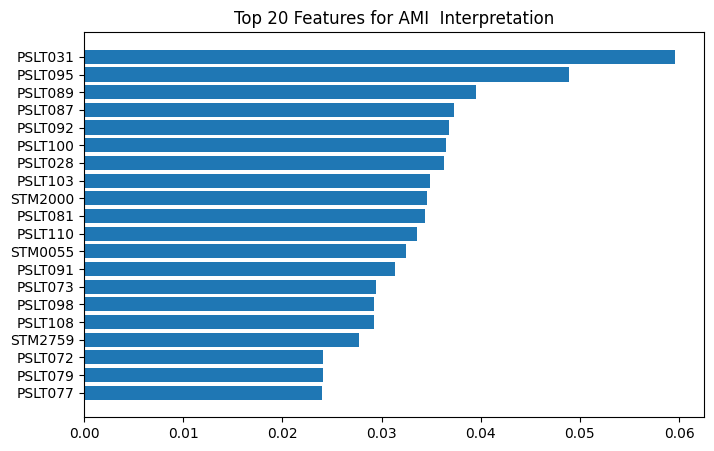

Top features for AMP Interpretation:
     Feature  Importance
178  STM2735    0.087304
99   STM2719    0.075391
71   PSLT031    0.066464
173  STM2000    0.044872
84   STM1029    0.043886
26   PSLT027    0.039638
131  PSLT028    0.031072
4    STM2701    0.028680
9    STM2718    0.025895
198  STM0055    0.024606
40   STM2710    0.024413
11   STM2723    0.024364
18   STM2707    0.023958
14   STM2706    0.023932
3    STM2697    0.022383
21   STM2736    0.021381
24   STM2695    0.021359
33   STM2699    0.020320
23   STM2730    0.019186
98   STM0554    0.018946


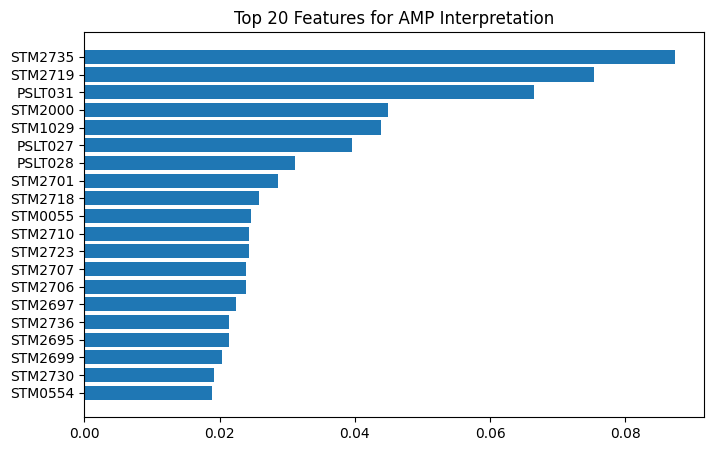

Top features for AZI Interpretation:
     Feature  Importance
28   STM2696    0.035264
178  STM2735    0.033680
116  STM0676    0.031621
173  STM2000    0.031579
23   STM2730    0.028976
71   PSLT031    0.028884
8    STM2729    0.024317
148  STM2716    0.023777
21   STM2736    0.023441
84   STM1029    0.023379
198  STM0055    0.023215
114  STM2233    0.023154
169  STM2702    0.022506
24   STM2695    0.022053
145  STM0323    0.022018
39   STM2240    0.020793
78   STM2732    0.020570
131  PSLT028    0.019987
94   STM2759    0.018954
33   STM2699    0.018345


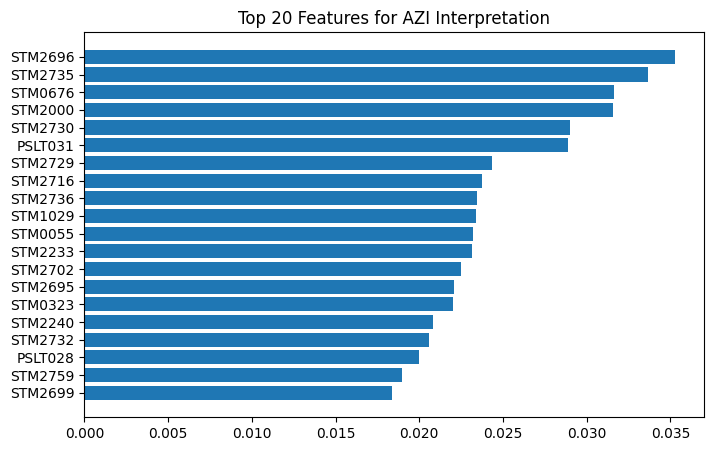

Top features for FOT Interpretation:
     Feature  Importance
99   STM2719    0.056988
198  STM0055    0.054278
39   STM2240    0.039066
131  PSLT028    0.037176
178  STM2735    0.036958
148  STM2716    0.031879
26   PSLT027    0.031846
169  STM2702    0.031642
71   PSLT031    0.028368
18   STM2707    0.026938
23   STM2730    0.025310
28   STM2696    0.025298
3    STM2697    0.024832
1    STM2714    0.024708
32   STM2722    0.024363
145  STM0323    0.022730
40   STM2710    0.021860
5    STM2728    0.021427
16   STM2715    0.021403
11   STM2723    0.020995


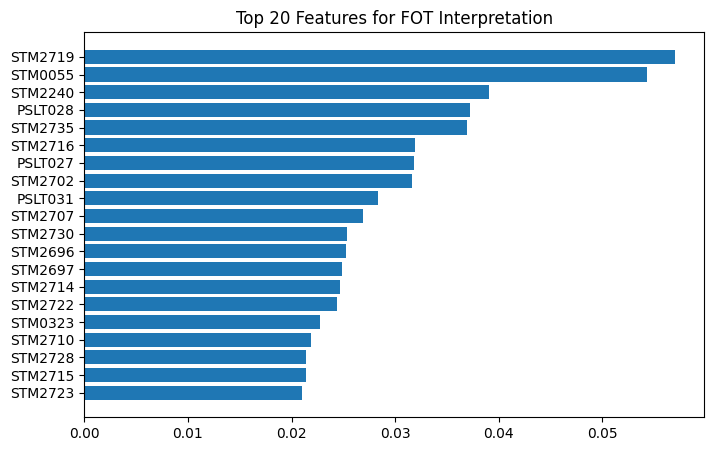

Top features for TAZ  Interpretation:
     Feature  Importance
84   STM1029    0.039038
8    STM2729    0.032451
173  STM2000    0.031520
28   STM2696    0.029801
24   STM2695    0.028915
21   STM2736    0.027298
0    STM2739    0.026993
131  PSLT028    0.026870
14   STM2706    0.026386
98   STM0554    0.025672
71   PSLT031    0.024641
39   STM2240    0.024576
11   STM2723    0.024101
169  STM2702    0.023970
198  STM0055    0.023038
12   STM2737    0.022791
148  STM2716    0.022479
114  STM2233    0.022448
18   STM2707    0.021524
178  STM2735    0.021289


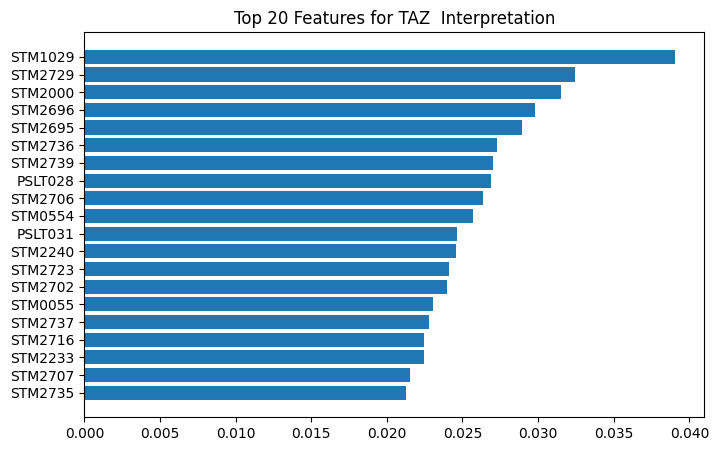

Top features for CHL Interpretation:
     Feature  Importance
59   STM2005    0.058216
173  STM2000    0.051535
15   STM2594    0.051340
94   STM2759    0.048114
33   STM2699    0.047924
99   STM2719    0.039584
71   PSLT031    0.033219
25   STM2708    0.033138
148  STM2716    0.028934
18   STM2707    0.027438
39   STM2240    0.027387
40   STM2710    0.026931
114  STM2233    0.026531
8    STM2729    0.023640
14   STM2706    0.021315
0    STM2739    0.020442
32   STM2722    0.020295
28   STM2696    0.019411
5    STM2728    0.018681
110  STM2703    0.018059


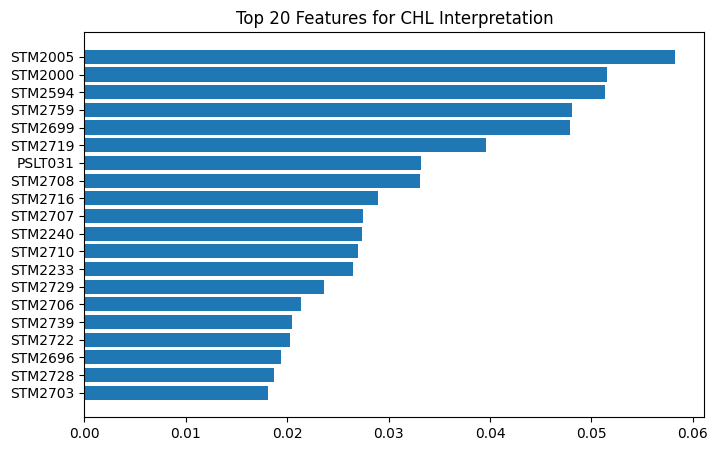

Top features for CIP Interpretation:
     Feature  Importance
84   STM1029    0.041206
148  STM2716    0.031458
78   STM2732    0.030978
59   STM2005    0.029895
18   STM2707    0.029845
24   STM2695    0.027746
173  STM2000    0.027666
28   STM2696    0.027627
12   STM2737    0.027418
16   STM2715    0.026431
98   STM0554    0.026379
8    STM2729    0.026298
15   STM2594    0.026086
94   STM2759    0.025945
14   STM2706    0.025017
114  STM2233    0.024915
11   STM2723    0.024445
4    STM2701    0.022425
23   STM2730    0.022363
1    STM2714    0.022198


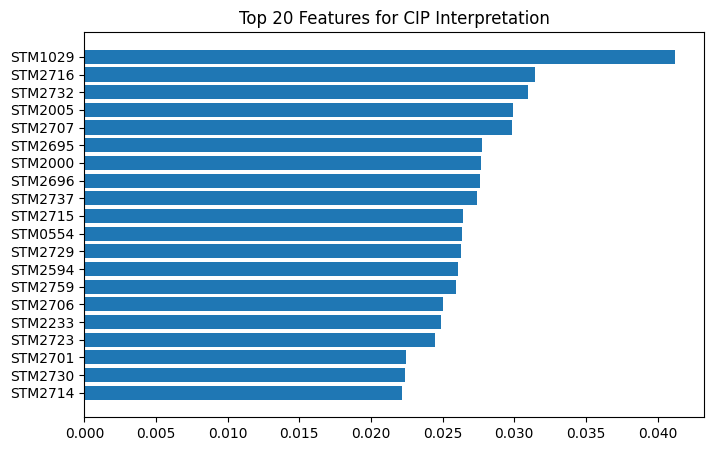

Top features for COL Interpretation:
     Feature  Importance
170  PSLT060    0.030873
24   STM2695    0.030015
78   STM2732    0.026644
28   STM2696    0.025696
21   STM2736    0.025565
8    STM2729    0.025258
99   STM2719    0.024958
23   STM2730    0.024015
178  STM2735    0.021867
94   STM2759    0.021581
47   PSLT108    0.020708
32   STM2722    0.020213
71   PSLT031    0.019766
114  STM2233    0.019568
41   PSLT103    0.019403
39   STM2240    0.019028
169  STM2702    0.018993
98   STM0554    0.018087
26   PSLT027    0.017989
86   PSLT092    0.017756


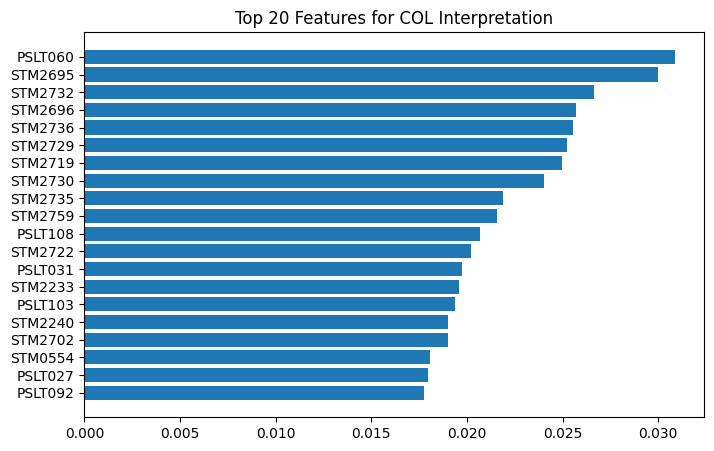

Top features for GEN Interpretation:
     Feature  Importance
6    STM2738    0.047205
7    STM2236    0.043780
12   STM2737    0.043262
20   STM2239    0.043200
16   STM2715    0.041090
2    PSLT053    0.039788
9    STM2718    0.039649
4    STM2701    0.039259
28   STM2696    0.038416
78   STM2732    0.035897
17   PSLT052    0.035667
8    STM2729    0.032396
26   PSLT027    0.029484
23   STM2730    0.028857
0    STM2739    0.028334
24   STM2695    0.026491
11   STM2723    0.025601
10   STM2721    0.025089
14   STM2706    0.023634
116  STM0676    0.023418


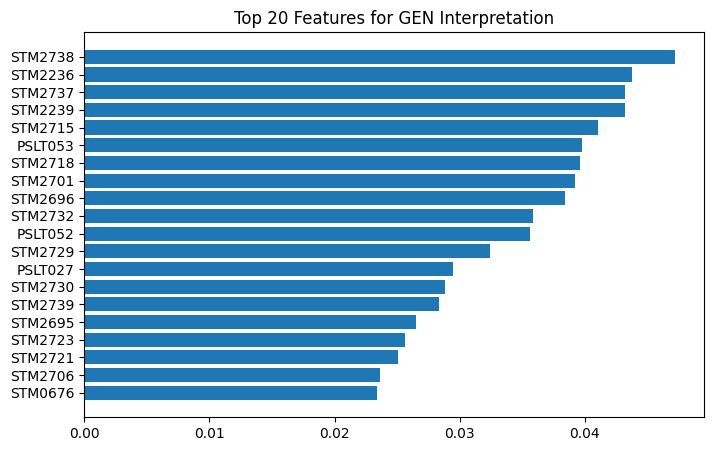

Top features for MERO Interpretation:
    Feature  Importance
0   STM2739         0.0
1   STM2714         0.0
2   PSLT053         0.0
3   STM2697         0.0
4   STM2701         0.0
5   STM2728         0.0
6   STM2738         0.0
7   STM2236         0.0
8   STM2729         0.0
9   STM2718         0.0
10  STM2721         0.0
11  STM2723         0.0
12  STM2737         0.0
13  PSLT054         0.0
14  STM2706         0.0
15  STM2594         0.0
16  STM2715         0.0
17  PSLT052         0.0
18  STM2707         0.0
19  PSLT055         0.0


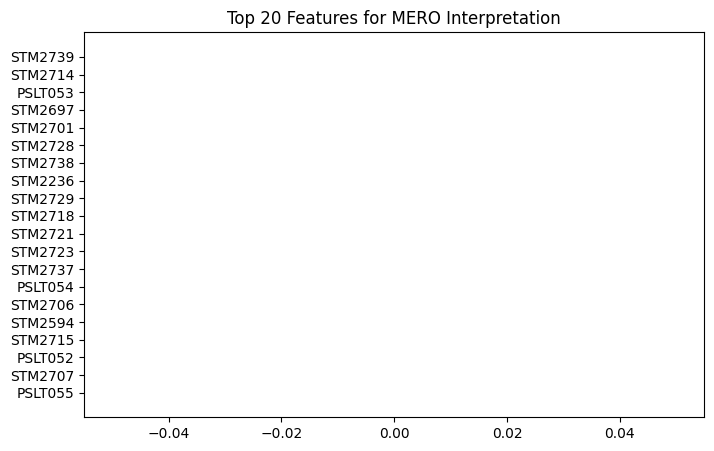

Top features for NAL  Interpretation:
     Feature  Importance
98   STM0554    0.036624
39   STM2240    0.033881
84   STM1029    0.030237
18   STM2707    0.029242
24   STM2695    0.029133
114  STM2233    0.028020
148  STM2716    0.027655
21   STM2736    0.026743
178  STM2735    0.024296
173  STM2000    0.024008
14   STM2706    0.023895
8    STM2729    0.023766
23   STM2730    0.022563
11   STM2723    0.021509
5    STM2728    0.021346
71   PSLT031    0.021049
198  STM0055    0.021042
26   PSLT027    0.020910
131  PSLT028    0.020224
99   STM2719    0.018987


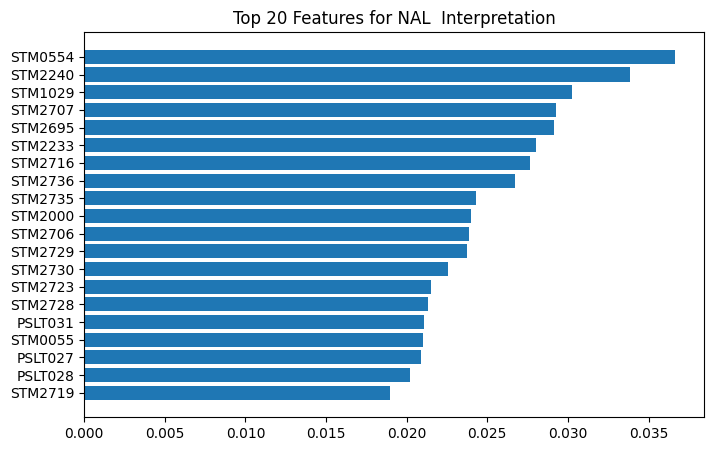

Top features for TET  Interpretation:
    Feature  Importance
0   STM2739         0.0
1   STM2714         0.0
2   PSLT053         0.0
3   STM2697         0.0
4   STM2701         0.0
5   STM2728         0.0
6   STM2738         0.0
7   STM2236         0.0
8   STM2729         0.0
9   STM2718         0.0
10  STM2721         0.0
11  STM2723         0.0
12  STM2737         0.0
13  PSLT054         0.0
14  STM2706         0.0
15  STM2594         0.0
16  STM2715         0.0
17  PSLT052         0.0
18  STM2707         0.0
19  PSLT055         0.0


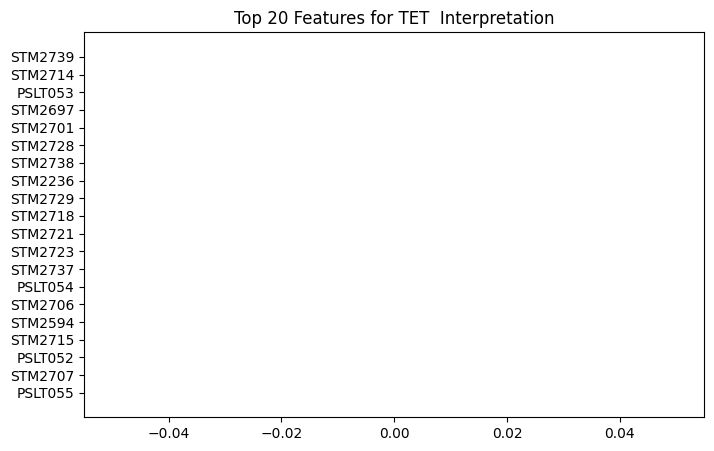

Top features for TGC  Interpretation:
     Feature  Importance
28   STM2696    0.065782
178  STM2735    0.043268
131  PSLT028    0.036842
39   STM2240    0.035759
148  STM2716    0.030152
198  STM0055    0.029674
23   STM2730    0.028358
24   STM2695    0.027678
8    STM2729    0.024472
78   STM2732    0.024288
94   STM2759    0.024052
173  STM2000    0.023516
21   STM2736    0.023397
11   STM2723    0.021715
145  STM0323    0.020820
116  STM0676    0.020565
169  STM2702    0.019907
84   STM1029    0.019827
71   PSLT031    0.019762
26   PSLT027    0.018963


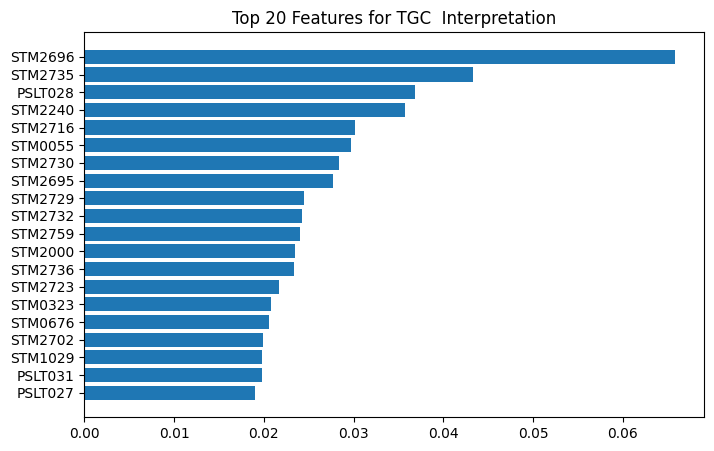

Top features for TMP Interpretation:
     Feature  Importance
17   PSLT052    0.049034
2    PSLT053    0.048433
12   STM2737    0.045806
7    STM2236    0.042204
20   STM2239    0.042072
6    STM2738    0.039123
9    STM2718    0.034604
13   PSLT054    0.034417
28   STM2696    0.031971
4    STM2701    0.031568
26   PSLT027    0.029908
16   STM2715    0.029529
8    STM2729    0.029474
23   STM2730    0.027019
10   STM2721    0.026847
78   STM2732    0.025751
24   STM2695    0.024827
0    STM2739    0.023954
71   PSLT031    0.023688
131  PSLT028    0.023546


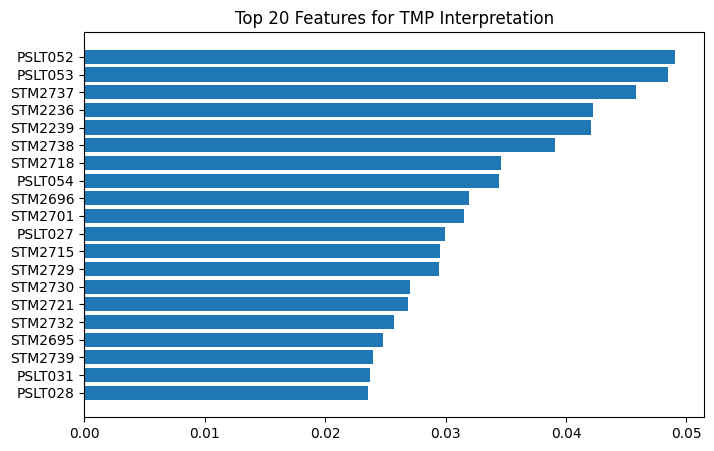

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract the underlying estimators
estimators = model.estimators_

feature_names = X_train.columns.tolist()
antibiotic_names = y_train.columns.tolist()

# Loop through each output and get feature importances
for i, est in enumerate(estimators):
    importances = est.feature_importances_
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(20)  # top 20

    print(f"Top features for {antibiotic_names[i]}:")
    print(fi_df)

    # Optional: plot
    plt.figure(figsize=(8,5))
    plt.barh(fi_df['Feature'], fi_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f"Top 20 Features for {antibiotic_names[i]}")
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Collect feature importances for all outputs
all_importances = []

for i, est in enumerate(model.estimators_):
    fi = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': est.feature_importances_,
        'Antibiotic': y_train.columns[i]
    })
    all_importances.append(fi)

# Concatenate into one DataFrame
fi_all = pd.concat(all_importances)

# Pivot: Features as rows, Antibiotics as columns
fi_pivot = fi_all.pivot_table(index='Feature', columns='Antibiotic', values='Importance', fill_value=0)

# Aggregate importance across antibiotics (mean, sum, or max)
fi_pivot['Mean_Importance'] = fi_pivot.mean(axis=1)
fi_pivot['Sum_Importance'] = fi_pivot.sum(axis=1)

# Sort by aggregate importance
top_shared_features = fi_pivot.sort_values('Mean_Importance', ascending=False).head(20)

print("Top 20 features shared across antibiotics:")
print(top_shared_features[['Mean_Importance', 'Sum_Importance']])


Top 20 features shared across antibiotics:
Antibiotic  Mean_Importance  Sum_Importance
Feature                                    
PSLT031            0.025827        0.387398
STM2696            0.024316        0.364733
STM2735            0.022880        0.343207
STM2000            0.022264        0.333956
STM2719            0.022212        0.333182
PSLT028            0.021622        0.324335
STM2729            0.020182        0.302729
STM2695            0.019513        0.292695
STM0055            0.019220        0.288296
PSLT027            0.019205        0.288069
STM2730            0.019179        0.287679
STM1029            0.019006        0.285090
STM2240            0.018722        0.280826
STM2736            0.018320        0.274805
STM2732            0.018103        0.271546
STM2716            0.017890        0.268353
STM2707            0.017504        0.262563
STM2723            0.017459        0.261882
STM2737            0.017294        0.259407
STM2759            0.017053      

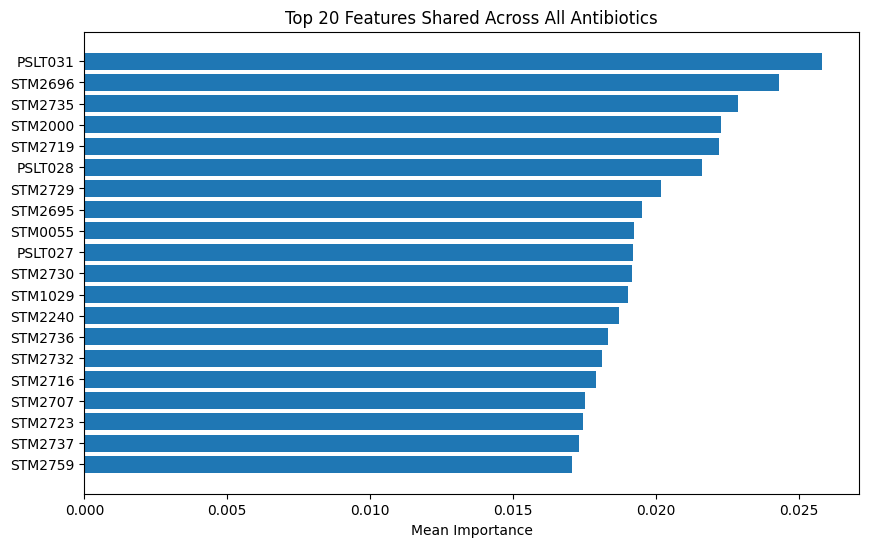

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top_shared_features.index, top_shared_features['Mean_Importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Features Shared Across All Antibiotics")
plt.xlabel("Mean Importance")
plt.show()
